In [465]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [466]:
def loadData (flow, meta):
    df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
    df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']
    df1['datetime'] = pd.to_datetime(df1[['Year', 'Mnth', 'Day']].rename(columns={'Year': 'year', 'Mnth': 'month', 'Day': 'day'}))
    df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)
    df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)
    df = pd.concat([df1, df2], axis=1)
    df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Hr'], axis=1, inplace=True)
    before = 3
    after = 7
    # for i in range(1, before + 1):
    #     df[f'Flow-{i}'] = df['Flow0'].shift(+i)  # Shift down by 1   
    for i in  range(1, after + 1):
        df[f'Flow+{i}'] = df['Flow0'].shift(-i)  # Shift up by 1   
    df = df.dropna()
    return df

In [467]:
def expand_mean(df):
    return df.expanding(1).mean()
def pct_diff(old, new):
    return (new-old) / old
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"

    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label], df[col])
    return df

# rolling_horizons = [3, 7]

# for horizon in rolling_horizons:
#     for col in ['prcp(mm/day)', 'srad(W/m2)', 'Flow0', 'tmax(C)', 'tmin(C)', 'vp(Pa)']:
#         df = compute_rolling(df, horizon, col)

# df = df.fillna(0)

# for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
#     df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
#     df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

In [468]:
def CAMELSrun(data_id, horizon1, horizon2, target_var, SYM_M):
    df = loadData(f'Data/Idaho/{data_id}_streamflow_qc.txt', f'Data/Idaho/{data_id}_lump_maurer_forcing_leap.txt')
    rolling_horizons = [horizon1, horizon2]

    for horizon in rolling_horizons:
        for col in ['prcp(mm/day)', 'srad(W/m2)', 'Flow0', 'tmax(C)', 'tmin(C)', 'vp(Pa)']:
            df = compute_rolling(df, horizon, col)

    df = df.fillna(0)

    for col in ['prcp(mm/day)', 'srad(W/m2)', 'Flow0', 'tmax(C)', 'tmin(C)', 'vp(Pa)']:
        df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
        df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

    # List of features to drop based on importance scores
    features_to_drop = [
        'SYM_A', 'SYM_A:e', 'SYM_nan', 'swe(mm)',
        'Year', 'Day', 
        # 'tmax(C)', 'tmin(C)', 
        # 'rolling_3_prcp(mm/day)', 'rolling_3_srad(W/m2)_pct',
        # 'rolling_3_tmax(C)_pct', 'rolling_3_tmin(C)_pct',
        # 'rolling_3_tmax(C)',
        # 'rolling_7_prcp(mm/day)', 'rolling_7_prcp(mm/day)_pct', 
        # 'rolling_7_tmax(C)', 'rolling_7_vp(Pa)',
        # 'rolling_7_tmin(C)_pct', 'rolling_7_tmax(C)_pct',
        'rolling_7_tmax(C)_pct', 'rolling_7_tmin(C)_pct',
        # 'rolling_14_srad(W/m2)_pct',
        # 'rolling_14_tmax(C)', 'rolling_14_tmin(C)', 
        # 'rolling_14_prcp(mm/day)', 'rolling_14_srad(W/m2)', 
        # 'rolling_14_tmax(C)_pct', 'rolling_14_tmin(C)_pct',
        # 'month_avg_vp(Pa)',
        # 'month_avg_tmax(C)',
        # 'month_avg_prcp(mm/day)',
        # 'month_avg_srad(W/m2)'
        # 'day_avg_vp(Pa)',
    ]

    if SYM_M:
        features_to_drop.append('SYM_M')
    # Drop the features from the DataFrame
    df = df.drop(columns=features_to_drop)

    Y = df[f'{target_var}']  # Target variable
    adjX = df.drop(['Flow+1', 'Flow+2', 'Flow+3', 'Flow+4', 'Flow+5', 'Flow+6', 'Flow+7'], axis=1)  # Features
    X = adjX.columns

    return df, X, Y

In [469]:
def visualization(datetime, y_pred, y_test, zoom_start, zoom_end):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - np.mean(mape)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {round(mae, 2)} m3/s")
    print(f"MSE: {round(mse, 2)} m3/s")
    print(f"RMSE: {round(np.sqrt(mse), 2)} m3/s")
    print(f"MAPE: {round(mape, 2)}%")
    print(f"Accuracy: {round(accuracy, 3)}%")
    print(f"R2: {round(r2, 4)}")
    
    # Plot Actual vs Predicted Streamflow Values
    plt.figure(figsize=(10, 6))
    plt.plot(datetime, y_test, label='Actual Flow', color='black')
    plt.plot(datetime, y_pred, label='Predicted Flow', linestyle='--', color='C0')
    plt.xlabel('Datetime')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Zoomed in Plot
    plt.figure(figsize=(10, 6))
    plt.plot(datetime, y_test, label='Actual Flow', color='black')
    plt.plot(datetime, y_pred, label='Predicted Flow', color='C0')
    plt.xlabel('Datetime')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values (Zoomed)')
    
    # Set the x and y limits to zoom in
    plt.xlim(datetime[zoom_start], datetime[zoom_end])
    plt.ylim(min(y_test[zoom_start:zoom_end].min(), y_pred[zoom_start:zoom_end].min()), 
             max(y_test[zoom_start:zoom_end].max(), y_pred[zoom_start:zoom_end].max()))
    
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Residuals Plot
    plt.figure(figsize=(10, 6))
    residuals = y_test - y_pred
    plt.plot(datetime, residuals, label='Residuals Flow+0')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Datetime')
    plt.ylabel('Residual (m3/s)')
    plt.title('Residuals for Each Day Ahead Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residuals Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals for Flow+0')
    plt.axhline(0, color='black', linestyle='--', label='Zero Residual Line')
    plt.xlabel('Predicted Streamflow (m3/s)')
    plt.ylabel('Residual (m3/s)')
    plt.title('Residual Scatter Plot for Each Day Ahead Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, label='Flow+0', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Streamflow (m3/s)')
    plt.ylabel('Predicted Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


In [470]:
df, X, Y = CAMELSrun('13340000', 3, 7, 'Flow+2', False)

C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [471]:
model = keras.Sequential([
    Dense(32, activation='relu', input_shape=(X.shape[0],), kernel_regularizer='l2'),
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dropout(0.1),
    Dense(1)
])


model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()




c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,921 (7.50 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

In [472]:
def print_model_weights_and_biases(model):
    for layer_idx, layer in enumerate(model.layers):
        weights = layer.get_weights()  # Returns a list: [weights, biases]
        print(f"Layer {layer_idx+1}: {layer.name}")
        
        if len(weights) > 0:  # Some layers (like Dropout) may not have weights
            print(f"  Weights shape: {weights[0].shape}")
            print(f"  Weights: {weights[0]}")
            
            if len(weights) > 1:  # If biases exist
                print(f"  Biases shape: {weights[1].shape}")
                print(f"  Biases: {weights[1]}")
        else:
            print("  No weights/biases for this layer.")

In [473]:
def permutation_importance(model, X_test, y_test, metric=mean_squared_error):
    baseline_score = metric(y_test, model.predict(X_test))
    importances = []
    
    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_score = metric(y_test, model.predict(X_test_permuted))
        importances.append(permuted_score - baseline_score)
    
    return np.array(importances)

In [474]:
def backtest(df, model, X, Y, train_window_size, test_window_size, drop_before_index):
    all_predictions = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    # feature_importances = np.zeros(len(X))
    
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Optionally drop rows before the specified index
    if drop_before_index is not None:
        df = df[df.index >= drop_before_index]

    num_iterations = 0




    if isinstance(Y, pd.Series):
        Y_column = Y.name
    else:
        Y_column = Y

    test_indices = []


    for i in range(0, df.shape[0] - train_window_size - test_window_size + 1, test_window_size):

        num_iterations += 1
        
        train = df.iloc[i:(i+train_window_size), :]
        test = df.iloc[(i+train_window_size):(i+train_window_size+test_window_size), :]
        
        test_indices.extend(test.index)

        X_train = train[X]
        X_train = scaler_X.fit_transform(X_train)

        X_test = test[X]
        X_test = scaler_X.transform(X_test)
        
        Y_train = train[[Y_column]]
        Y_train = scaler_Y.fit_transform(Y_train).reshape(-1, 1) 

        Y_test = test[[Y_column]]
        Y_test = scaler_Y.transform(Y_test).reshape(-1, 1) 

        model.fit(X_train, Y_train, epochs=15, verbose=1, validation_split=0.2, callbacks=[early_stopping])

        preds = model.predict(X_test)

        preds = scaler_Y.inverse_transform(preds).reshape(-1, 1).flatten() 
        Y_test = scaler_Y.inverse_transform(Y_test).reshape(-1, 1).flatten()

        combined = pd.DataFrame({
            "actual": Y_test,
            "prediction": preds
        }, index=test.index)

        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        all_predictions.append(combined)

    #     importances = permutation_importance(model, X_test, Y_test)
    #     feature_importances += importances


    # avg_feature_importances = feature_importances / num_iterations
    
    # for i, importance in enumerate(avg_feature_importances):
    #     print(f"Feature: {X[i]}, Importance: {importance}")

    all_predictions = pd.concat(all_predictions, axis=0)

    # Create a datetime index for all test predictions
    datetime = pd.Index(test_indices)

    return all_predictions, datetime

In [475]:
def standardtest(df, model, X, Y):
    all_predictions = []
    
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Y = np.log1p(Y)

    if isinstance(Y, pd.Series):
        Y_column = Y.name
    else:
        Y_column = Y

    X_test = df[X]
    X_test = scaler_X.fit_transform(X_test)

    # Y_test = np.log1p(test[[Y_column]])
    Y_test = df[[Y_column]]
    Y_test = scaler_Y.fit_transform(Y_test).reshape(-1, 1) 

    preds = model.predict(X_test)

    preds = scaler_Y.inverse_transform(preds).reshape(-1, 1).flatten() 
    Y_test = scaler_Y.inverse_transform(Y_test).reshape(-1, 1).flatten()

    # preds = np.expm1(preds)  # Reverse the log1p transformation.
    # Y_test = np.expm1(Y_test)  # Reverse the log1p transformation for the test data as well.

    combined = pd.DataFrame({
        "actual": Y_test,
        "prediction": preds
    })

    combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

    all_predictions.append(combined)

    all_predictions = pd.concat(all_predictions, axis=0)

    # Create a datetime index for all test predictions
    datetime = df.index

    return all_predictions, datetime


In [476]:
df, X, Y = CAMELSrun('04045500', 3, 7, 'Flow+7', True)

C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)


C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [477]:
predictions, datetime1 = backtest(df, model, X, Y, 540, 60, None)
y_pred = predictions["prediction"]
y_test = predictions["actual"]

y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions
y_pred = np.minimum(y_pred, np.max(y_test) * 1.1)  # Cap predictions at 10% above max value of y_test

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.2650 - mean_squared_error: 0.6899 - val_loss: 2.6483 - val_mean_squared_error: 2.0841
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0368 - mean_squared_error: 0.4759 - val_loss: 2.1583 - val_mean_squared_error: 1.6077
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8697 - mean_squared_error: 0.3228 - val_loss: 1.8348 - val_mean_squared_error: 1.2987
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8654 - mean_squared_error: 0.3329 - val_loss: 1.6510 - val_mean_squared_error: 1.1293
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8424 - mean_squared_error: 0.3242 - val_loss: 1.5060 - val_mean_squared_error: 0.9985
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6847 - mean_squared_error: 0.1807 - val_loss: 1.3963 - val_mean_squared_error: 0.9032
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6463 - mean_squared_error: 0.1569 - val_loss: 1.2962 - val_mean

MAE: 244.33 m3/s
MSE: 156892.2 m3/s
RMSE: 396.1 m3/s
MAPE: 0.33%
Accuracy: 99.673%
R2: 0.7785


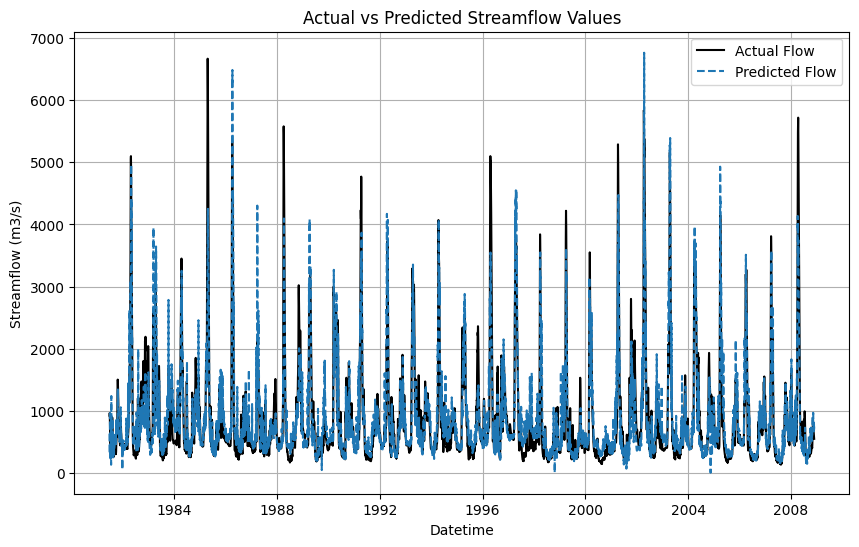

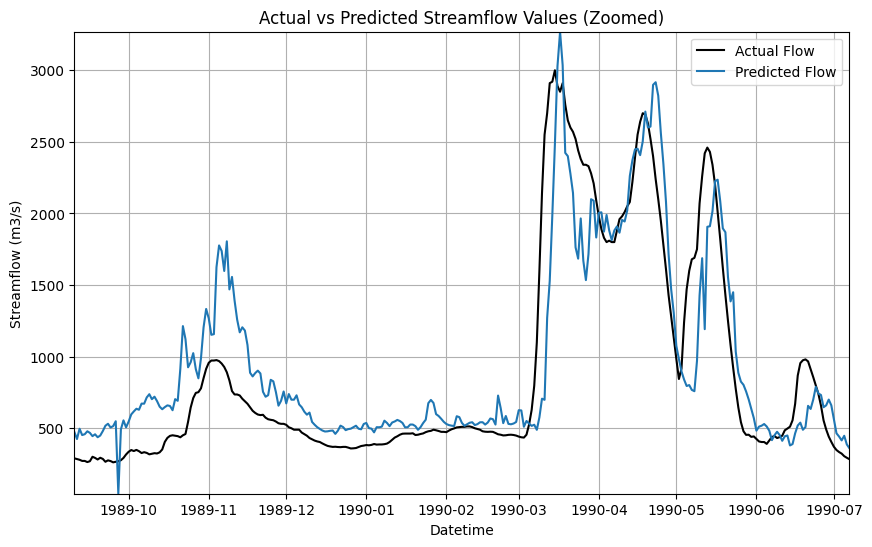

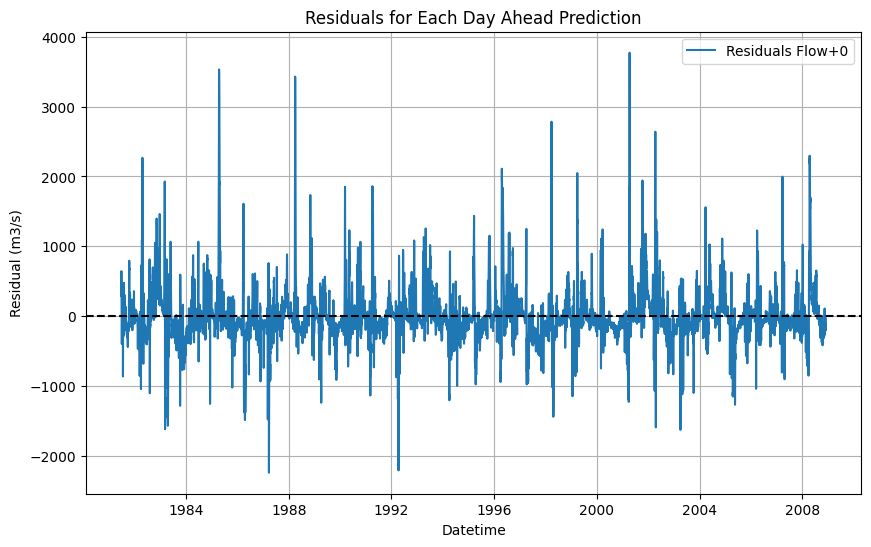

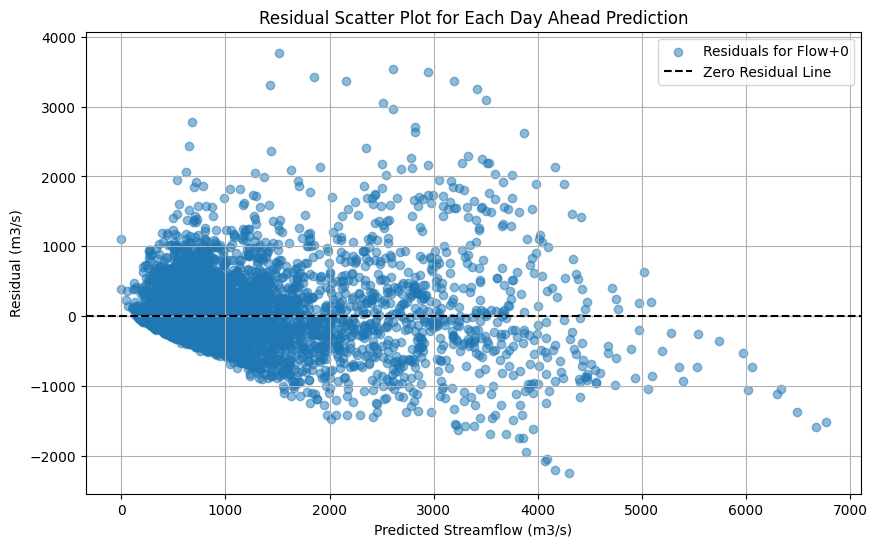

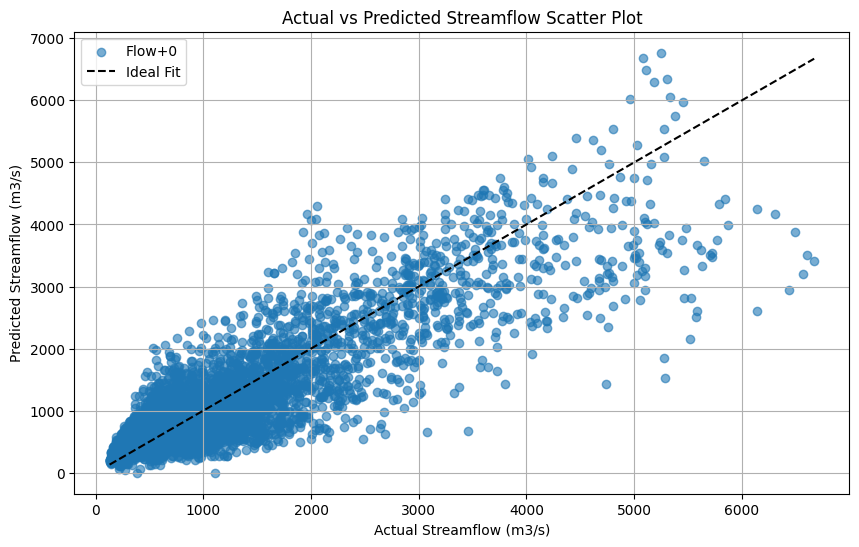

Layer 1: dense_60
  Weights shape: (42, 32)
  Weights: [[-0.07356896 -0.05801611 -0.03552179 ...  0.11510383 -0.12747271
   0.0528645 ]
 [-0.01852644 -0.00725824  0.03237228 ... -0.00761289 -0.0267524
  -0.01660869]
 [ 0.01176179 -0.03236522 -0.00364395 ... -0.0063323   0.01037568
  -0.0029736 ]
 ...
 [-0.01561813 -0.05021479  0.01776744 ...  0.00147383 -0.02716007
   0.00090048]
 [-0.00377202 -0.00162337  0.01716823 ... -0.02525774  0.03687052
  -0.02683516]
 [-0.00771125 -0.02170342  0.01993819 ... -0.01311228  0.01924618
   0.00048817]]
  Biases shape: (32,)
  Biases: [ 0.11716384  0.03711091  0.06148006 -0.14115359  0.07881931 -0.12777677
 -0.10594486  0.23405781  0.04007207  0.23366353 -0.22096352  0.13484894
  0.00970031  0.07699861  0.01629849 -0.12505494  0.04529741  0.03703158
  0.02794813 -0.15061364 -0.14993614  0.12502179  0.00216543 -0.09262683
  0.11704337 -0.25239366  0.08680022  0.0499979   0.07594962 -0.07763602
  0.10016099 -0.09957221]
Layer 2: dropout_40
  No weight

In [478]:
visualization(datetime1, y_pred, y_test, 3000,3300)
print_model_weights_and_biases(model)

In [479]:
df, X, Y = CAMELSrun('13340000', 3, 7, 'Flow+2', False)

C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [480]:
predictions1, datetime2 = backtest(df, model, X, Y, 365, 60, None)

y_pred1 = predictions1["prediction"]
y_test1 = predictions1["actual"]

y_pred1 = np.maximum(y_pred1, 0)  # Ensure no negative predictions1
y_pred1 = np.minimum(y_pred1, np.max(y_test1) * 1.1)  # Cap predictions1 at 10% above max value of y_test

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4599 - mean_squared_error: 0.4299 - val_loss: 0.3463 - val_mean_squared_error: 0.3161
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1710 - mean_squared_error: 0.1408 - val_loss: 0.2581 - val_mean_squared_error: 0.2275
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1035 - mean_squared_error: 0.0729 - val_loss: 0.2377 - val_mean_squared_error: 0.2076
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0827 - mean_squared_error: 0.0528 - val_loss: 0.2302 - val_mean_squared_error: 0.2009
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0938 - mean_squared_error: 0.0645 - val_loss: 0.2185 - val_mean_squared_error: 0.1895
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0914 - mean_squared_error: 0.0624 - val_loss: 0.2134 - val_mean_squared_error: 0.1845
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0851 - mean_squared_error: 0.0563 - val_loss: 0.2093 - val_mean_

MAE: 1632.77 m3/s
MSE: 9380172.16 m3/s
RMSE: 3062.71 m3/s
MAPE: 0.28%
Accuracy: 99.716%
R2: 0.9104


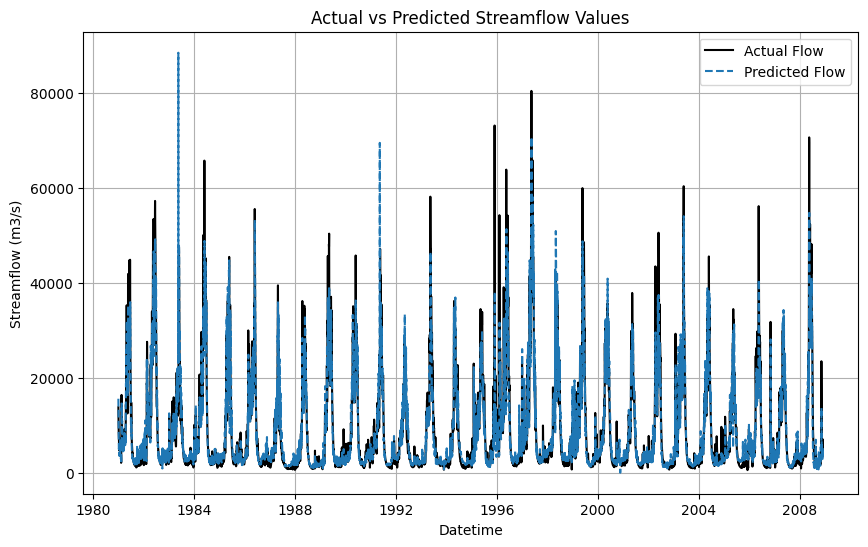

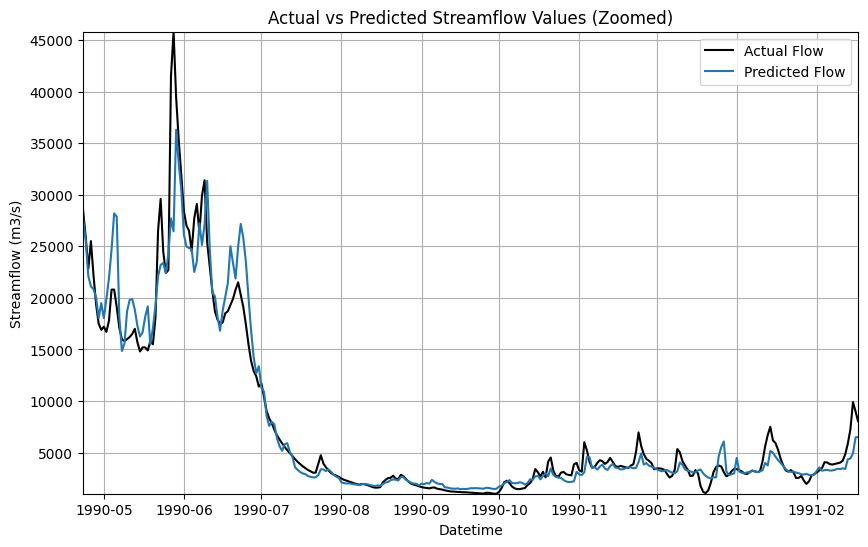

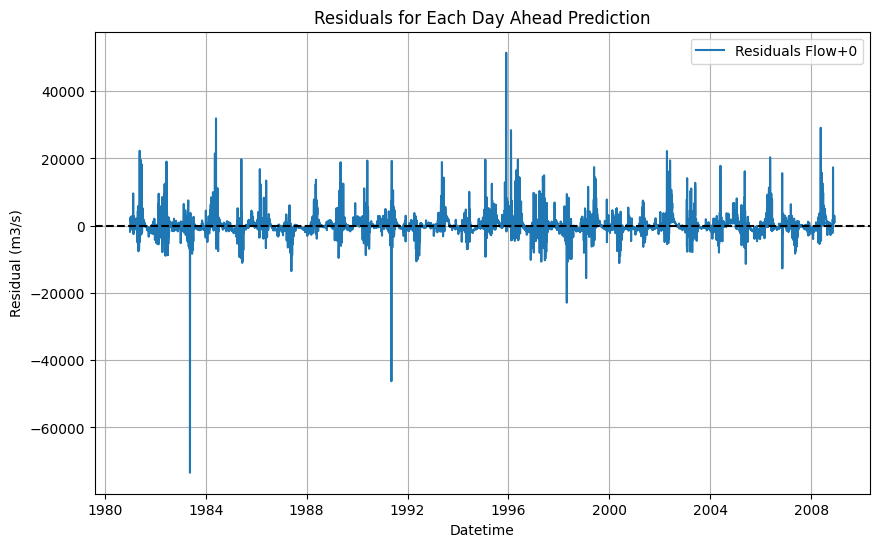

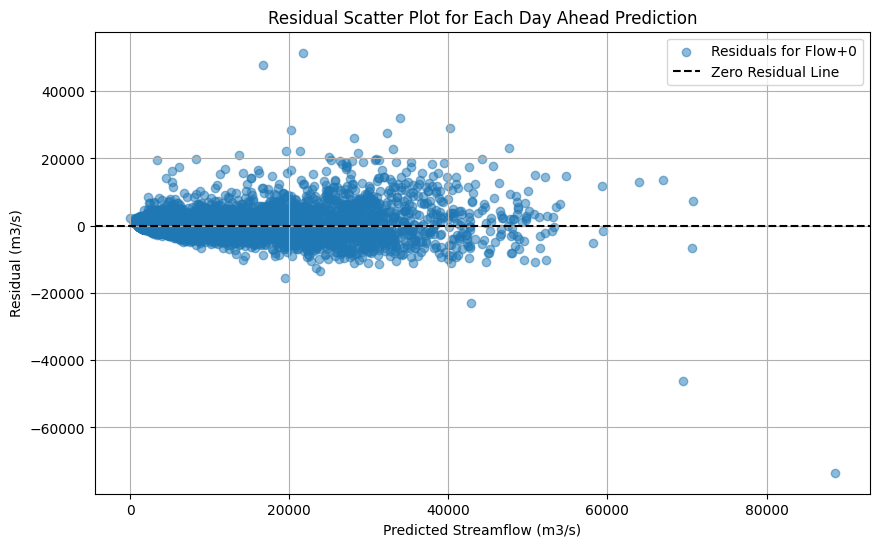

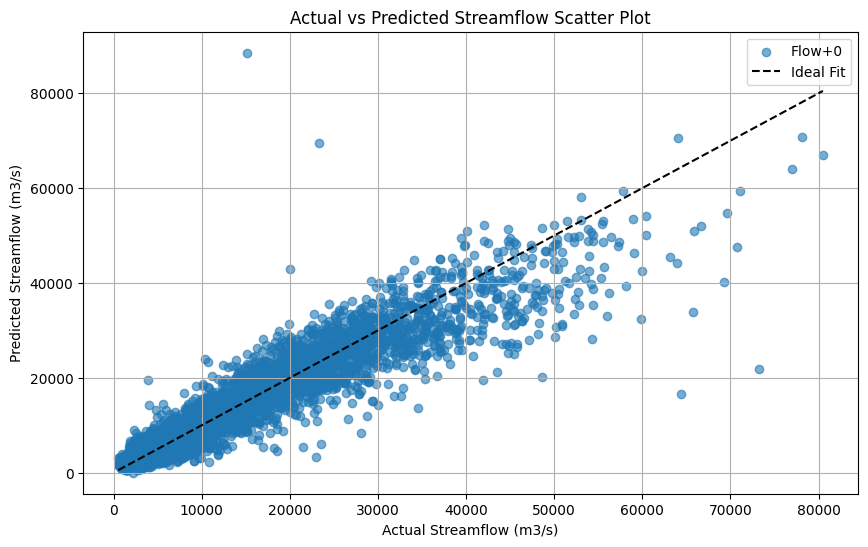

Layer 1: dense_60
  Weights shape: (42, 32)
  Weights: [[-7.1566261e-02 -1.0451375e-02 -2.5128402e-02 ...  1.0682570e-01
  -6.2831767e-02  6.9774918e-02]
 [ 5.8870865e-03  7.0603746e-03  1.0348617e-02 ...  6.3231648e-03
  -1.7429242e-02 -1.2426202e-02]
 [-1.1416361e-02 -1.4929946e-02 -2.5083795e-02 ...  4.1417396e-03
  -2.8805887e-02  4.0950351e-03]
 ...
 [ 1.3968561e-02 -1.4754823e-02 -4.7272779e-03 ... -1.6738528e-02
   5.4963506e-03 -1.8303610e-02]
 [ 4.0564104e-03 -6.0032648e-03 -6.0789948e-03 ... -2.1116642e-02
  -3.9613312e-03 -3.3649325e-02]
 [ 1.7187256e-02 -9.5983204e-03 -5.5648616e-06 ... -3.0886400e-02
   1.7088646e-03 -3.2637164e-02]]
  Biases shape: (32,)
  Biases: [ 0.20655169  0.11685265  0.17357863 -0.14978112  0.07110152 -0.1579832
 -0.16185714  0.22099496  0.01040942  0.26340327 -0.2613837   0.18527178
  0.08523712  0.10029475  0.10864038 -0.1795011   0.10513667  0.11380482
  0.13575171 -0.20639768 -0.2024958   0.10850677  0.12130123 -0.14623442
  0.2191491  -0.303469

In [481]:
visualization(datetime2, y_pred1, y_test1, 3400, 3700)
print_model_weights_and_biases(model)

In [482]:
df, X, Y = CAMELSrun('05131500', 3, 7, 'Flow+2', False)

C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_19856\2664073335.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [483]:
predictions2, datetime3 = backtest(df, model, X, Y, 540, 60, pd.Timestamp('2004-01-01'))

y_pred2 = predictions2["prediction"]
y_test2 = predictions2["actual"]

y_pred2 = np.maximum(y_pred2, 0)  # Ensure no negative predictions2
y_pred2 = np.minimum(y_pred2, np.max(y_test2) * 1.1)  # Cap predictions2 at 10% above max value of y_test


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1555 - mean_squared_error: 0.1403 - val_loss: 0.7689 - val_mean_squared_error: 0.7538
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1107 - mean_squared_error: 0.0954 - val_loss: 0.5799 - val_mean_squared_error: 0.5641
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0900 - mean_squared_error: 0.0740 - val_loss: 0.6034 - val_mean_squared_error: 0.5874
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0697 - mean_squared_error: 0.0538 - val_loss: 0.5799 - val_mean_squared_error: 0.5641
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0785 - mean_squared_error: 0.0626 - val_loss: 0.5546 - val_mean_squared_error: 0.5383
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0764 - mean_squared_error: 0.0600 - val_loss: 0.5505 - val_mean_squared_error: 0.5341
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0867 - mean_squared_error: 0.0702 - val_loss: 0.5340 - val_mean_

MAE: 271.65 m3/s
MSE: 287108.79 m3/s
RMSE: 535.83 m3/s
MAPE: 1.0%
Accuracy: 98.998%
R2: 0.8614


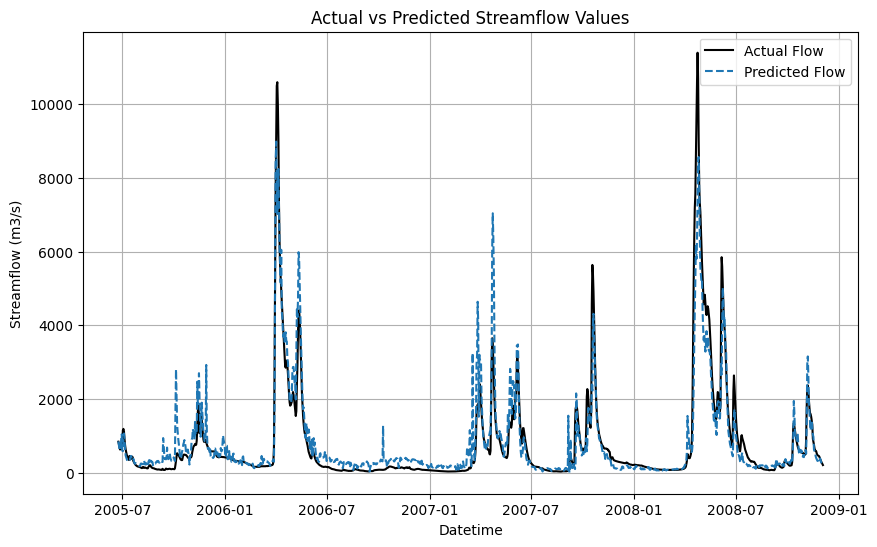

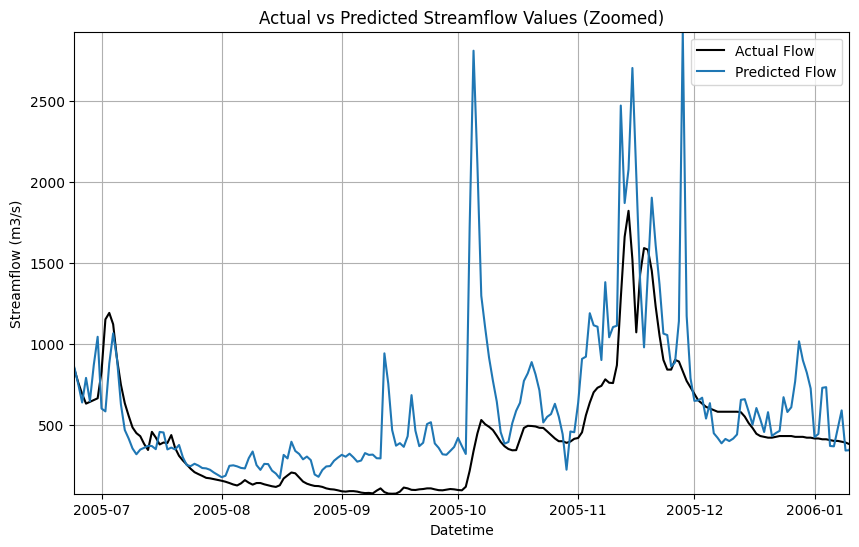

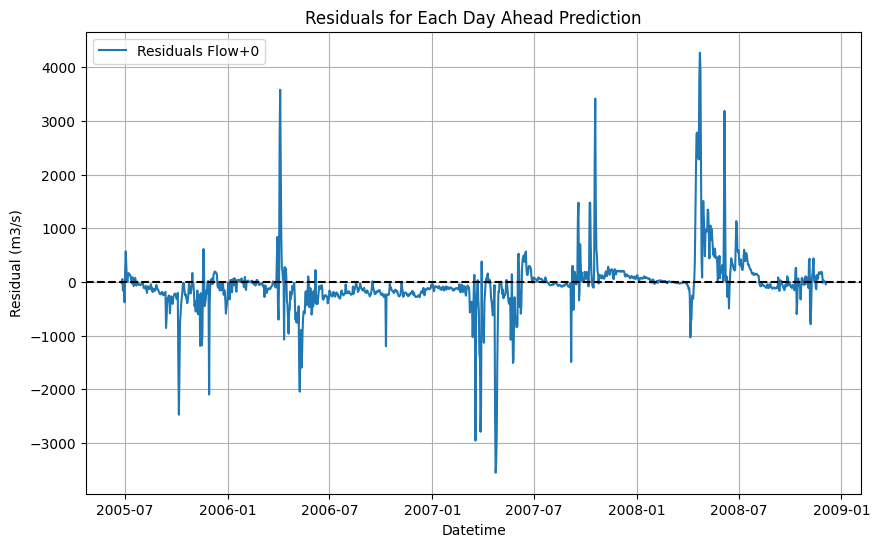

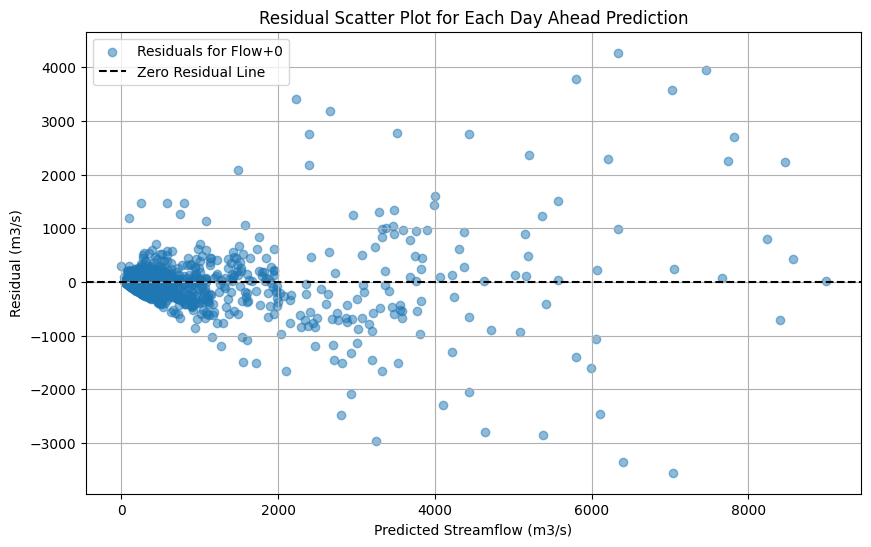

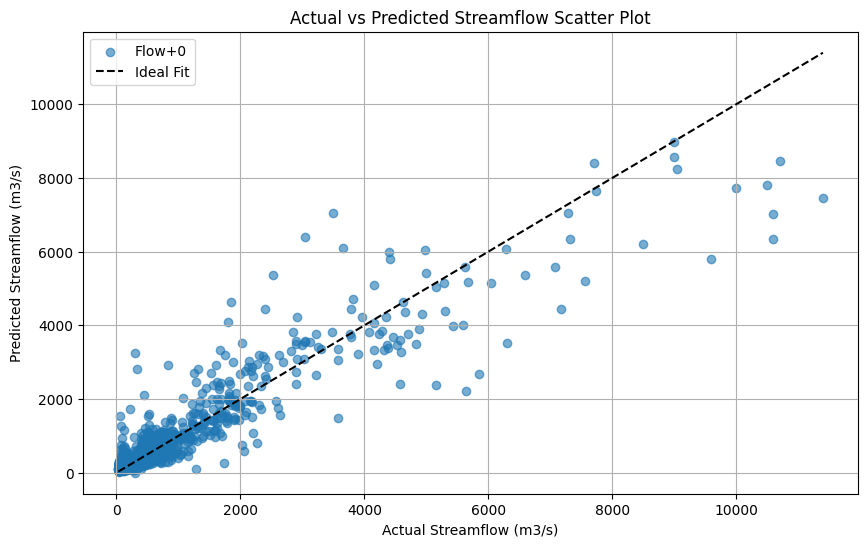

Layer 1: dense_60
  Weights shape: (42, 32)
  Weights: [[-0.06725717 -0.01287187 -0.03710619 ...  0.11368618 -0.08407766
   0.06686524]
 [ 0.0048395   0.00827012 -0.01081829 ... -0.02774109 -0.02005216
  -0.01079653]
 [-0.0027042   0.01223565 -0.02069215 ...  0.01822166 -0.00506677
  -0.00431558]
 ...
 [ 0.00013351  0.01253244 -0.03022311 ... -0.01828722 -0.00700144
  -0.01927001]
 [ 0.0102007   0.00444831 -0.0121027  ... -0.03315395  0.00986408
  -0.01399533]
 [ 0.01367061  0.01472524 -0.01158615 ... -0.05423994  0.01714799
  -0.0321286 ]]
  Biases shape: (32,)
  Biases: [ 0.25224084  0.12500997  0.15657325 -0.14978112  0.07948826 -0.15510888
 -0.16868784  0.22367656  0.00249402  0.31381023 -0.27956647  0.21477748
  0.03916582  0.09892655  0.13683158 -0.20654337  0.1577048   0.12830132
  0.16335842 -0.21395758 -0.21423738  0.10421842  0.09783213 -0.15252742
  0.28577638 -0.30215007  0.15219417  0.10993306  0.21049167 -0.11735407
  0.1566309  -0.17108557]
Layer 2: dropout_40
  No weigh

In [484]:
visualization(datetime3, y_pred2, y_test2, 0, 200)
print_model_weights_and_biases(model)

In [485]:
# def montecarlo(df, X, Y, num_samples=100, num_steps=7):

#     # num_steps: Number of future time steps to predict 
#     # num_samples: Number of Monte Carlo samples to draw

#     scaler_X = StandardScaler()
#     scaler_Y = StandardScaler()

#     model.trainable = True
#     all_predictions = []




#     if isinstance(Y, pd.Series):
#         Y_column = Y.name
#     else:
#         Y_column = Y

#     test_indices = []

#     # Fitting???

#     samples = df.iloc[-num_samples:, :]
#     X_samples = samples[X]
#     X_scaled = scaler_X.fit_transform(X_samples)
#     Y_samples = samples[[Y_column]]
#     Y_scaled = scaler_Y.fit_transform(Y_samples).reshape(-1, 1)


#     for _ in range(num_samples):
#         # Generate future predictions
#         predictions = []
#         lastX = X_scaled[-1]  # Start with the last known scaled input data

#         for _ in range(num_steps):
#             pred = model.predict(lastX, verbose=0)
#             pred = scaler_Y.inverse_transform(pred).reshape(-1, 1).flatten()    # Inverse scale the prediction
#             predictions.append(pred)

#             lastX = np.roll(lastX, -1)  # Shift the input data to simulate time step
#             lastX[-1] = pred

#         all_predictions.append(np.array(predictions).flatten())


#     # Convert to numpy array for easy manipulation
#     all_predictions = np.array(all_predictions)

#     # Calculate mean and uncertainty bounds
#     mean_prediction = np.mean(all_predictions, axis=0)
#     lower_bound = np.percentile(all_predictions, 5, axis=0)
#     upper_bound = np.percentile(all_predictions, 95, axis=0)

#     # Inverse scale the original last 100 Y values
#     Y_original_scaled = scaler_Y.inverse_transform(Y_scaled).reshape(-1, 1).flatten()

#     # Plotting
#     plt.plot(range(100), Y_original_scaled, label='Original Data', color='blue')
#     plt.plot(range(100, 130), mean_prediction, label='Forecasted Trend', color='orange')
#     plt.fill_between(range(100, 130), lower_bound, upper_bound, color='gray', alpha=0.5, label='95% Confidence Interval')
#     plt.legend()
#     plt.show()

# montecarlo(df, X, Y)